In [1]:
%matplotlib notebook

In [2]:
import ROOT
from ROOT import TFile, TTree, TCanvas, TH2D, TH1F
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

Welcome to JupyROOT 6.22/09


In [3]:
f = TFile("selectedEventsTrueRecoBoth_withTrueTrkDir_withParticleEs_111124.root","READ") # have particle energies, AND corrected so everything is in GeV
#f = TFile("selectedEventsTrueRecoBoth_withTrueTrkDir_110424.root","READ") # has truth px/py/pz etc
#f = TFile("selectedEventsTrueRecoBoth_withTrkDir_wuthTrackComp_102824.root","READ") # with track completeness score
#f = TFile("selectedEventsTrueRecoBoth_withTrkDir_102824.root","READ") 

t = f.Get("selectedEvents")

entries = t.GetEntries()
print(entries)

10913


In [4]:
t.GetEntry(5)

def getTransverseAxis(eNu, pxMu, pyMu, pzMu):
    pV = np.array([0, 0, eNu])
    pMu = np.array([pxMu, pyMu, pzMu])
    z = np.cross(pV, pMu)
    magZ = np.sqrt( z[0]**2 + z[1]**2 + z[2]**2 )
    #return z / magZ
    return z / np.linalg.norm(z) # same as my magZ eqn above

print(t.recoSel_recoNuE_)
print(t.recoSel_trkDirMuX_)
print(t.recoSel_trkDirMuY_)
print(t.recoSel_trkDirMuZ_)

z = getTransverseAxis(t.recoSel_recoNuE_,t.recoSel_trkDirMuX_,t.recoSel_trkDirMuY_,t.recoSel_trkDirMuZ_)

print("z: ", z )

0.48742047119140625
0.053709817209715204
-0.13113712865486582
0.21879997807629656
z:  [ 0.92539155  0.3790125  -0.        ]


In [5]:
t.GetEntry(5)

pPi = np.array([t.recoSel_trkDirPiX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPiZ_])
pP = np.array([t.recoSel_trkDirPX_, t.recoSel_trkDirPY_, t.recoSel_trkDirPZ_])
print(pPi)
print(pP)

# 1st TKI observable, double-transverse momentum imbalance
def delPTT(z, pPi, pP): 
    pPiTT = np.dot(z,pPi)
    pPTT = np.dot(z,pP)
    return pPiTT + pPTT

print( delPTT(z, pPi, pP) )

[-0.10935544 -0.04122055 -0.01128636]
[-0.21189227  0.00324651  0.37416956]
-0.3116725511591243


In [6]:
t.GetEntry(5)

# sum of transverse momenta of the 3 particles
def delPT(pxPi, pxP, pxMu, pyPi, pyP, pyMu): 
    pTMu = np.array([pxMu, pyMu, 0])
    pTP = np.array([pxP, pyP, 0])
    pTPi = np.array([pxPi, pyPi, 0])
    return pTMu + pTPi + pTP

delPT_test = delPT(t.recoSel_trkDirPiX_, t.recoSel_trkDirPX_, t.recoSel_trkDirMuX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPY_, t.recoSel_trkDirMuY_)
print(delPT_test)

[-0.26753789 -0.16911117  0.        ]


In [7]:
t.GetEntry(5)

epsilon = 0.0309

# longitudinal component, the long way
def pL(pzP, pzMu, pzPi, eP, eMu, ePi, delPT): 
    mP = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000 
    #print("mP: ", mP)
    mN = constants.physical_constants['neutron mass energy equivalent in MeV'][0]/1000
    #print("mN: ", mN)
    B = 0.34381
    mA = 22*mN + 18*mP - B
    mA1 = mA - mN + epsilon
    del2 = np.dot(delPT, delPT)
    #pLP = np.array([0, 0, pzP])
    #pLMu = np.array([0, 0, pzMu])
    #pLPi = np.array([0, 0, pzPi])
    parens = mA + pzMu + pzPi + pzP - eMu - ePi - eP
    return 0.5*(parens) - 0.5*((del2+mA1**2)/(parens))

pL_test = pL(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_, delPT_test)
#print(t.pzP_)
print("pL_test: ", pL_test)

def pLGKI(pzP, pzMu, pzPi, eP, eMu, ePi):
    pRest = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000
    piRest = 139.57/1000 # GeV
    #print("piRest:", piRest)
    #Ecal = eMu + (eP-pRest) + (ePi-piRest) + epsilon
    Ecal = eMu + (eP-pRest) + ePi + epsilon
    return pzMu + pzP + pzPi - Ecal

pLGKI_test = pLGKI(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_)
print("pLGKI_test: ", pLGKI_test)

pL_test:  -0.006847073443509544
pLGKI_test:  -0.006760224706575335


In [8]:
# 3rd TKI observable, boosting angle
def delAlphaT(pxMu, pyMu, delPT): 
    pTMu = np.array([pxMu, pyMu, 0])
    magPTMu = np.sqrt( pTMu[0]**2 + pTMu[1]**2 + pTMu[2]**2 )
    magDelPT = np.sqrt( delPT[0]**2 + delPT[1]**2 + delPT[2]**2 )
    dot = np.dot(-pTMu,delPT)
    return np.arccos(dot / (magPTMu * magDelPT))

delAlphaT_test = delAlphaT(t.recoSel_trkDirMuX_, t.recoSel_trkDirMuY_, delPT_test)
print(delAlphaT_test)

1.7457572653823448


In [9]:
reco_delPTT_list = []
reco_delPT_list = []
reco_pL_list = []
reco_pLGKI_list = []
reco_pN_list = []
reco_pNGKI_list = []
reco_delAlphaT_list = []

truth_delPTT_list = []
truth_delPT_list = []
truth_pL_list = []
truth_pLGKI_list = []
truth_pN_list = []
truth_pNGKI_list = []
truth_delAlphaT_list = []

reco_weights_list = []
truth_weights_list = []

entries = t.GetEntries()

completeness = 0.5

# main loop
for e in range(entries):

    t.GetEntry(e)
    
    if (t.passedSel_ == 2) or (t.passedSel_ == 3): # passes reco selection
    #if (t.passedSel_ == 2) or (t.passedSel_ == 3) and (t.recoSel_trackCompMu_ > completeness) and (t.recoSel_trackCompPi_ > completeness) and (t.recoSel_trackCompP_ > completeness) and (t.recoSel_recoContained_==2): 
    #if (t.passedSel_ == 3): # passes both selection
    #if (t.passedSel_ == 3) and (t.recoSel_trackCompMu_ > completeness) and (t.recoSel_trackCompPi_ > completeness) and (t.recoSel_trackCompP_ > completeness) and (t.recoSel_recoContained_==2): 
    #if (t.passedSel_ == 3) and (t.recoSel_trackCompMu_ > completeness) and (t.recoSel_trackCompPi_ > completeness) and (t.recoSel_trackCompP_ > completeness): 
    #if (t.passedSel_ == 3) and (t.recoSel_recoContained_==2): 


        
        pPi = np.array([t.recoSel_trkDirPiX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPiZ_])
        pP = np.array([t.recoSel_trkDirPX_, t.recoSel_trkDirPY_, t.recoSel_trkDirPZ_])
    
        z = getTransverseAxis(t.recoSel_recoNuE_,t.recoSel_trkDirMuX_,t.recoSel_trkDirMuY_,t.recoSel_trkDirMuZ_)
        
        reco_delPTT_list.append( delPTT(z, pPi, pP) )
        
        reco_delPT_entry = delPT(t.recoSel_trkDirPiX_, t.recoSel_trkDirPX_, t.recoSel_trkDirMuX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPY_, t.recoSel_trkDirMuY_)
        reco_delPT_list.append( reco_delPT_entry )
    
        reco_pL_entry = pL(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_, reco_delPT_entry)
        reco_pLGKI_entry = pLGKI(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_)
    
        reco_pL_list.append( reco_pL_entry )
        reco_pLGKI_list.append( reco_pLGKI_entry )
    
        reco_pN = np.sqrt( np.dot(reco_delPT_entry, reco_delPT_entry) + np.dot(reco_pL_entry, reco_pL_entry) )
        reco_pN_list.append(reco_pN)
    
        reco_pNGKI = np.sqrt( np.dot(reco_delPT_entry, reco_delPT_entry) + np.dot(reco_pLGKI_entry, reco_pLGKI_entry) )
        reco_pNGKI_list.append(reco_pNGKI)
    
        reco_delAlphaT_list.append( delAlphaT(t.recoSel_trkDirMuX_, t.recoSel_trkDirMuY_, reco_delPT_entry) )
        
        reco_weights_list.append(t.weight_)
        
    if (t.passedSel_ == 1) or (t.passedSel_ == 3): # passes truth selection
        #if (t.passedSel_ == 3): # passes both selection
        
        pPi = np.array([t.truthSel_pxPi_, t.truthSel_pyPi_, t.truthSel_pzPi_])
        pP = np.array([t.truthSel_pxP_, t.truthSel_pyP_, t.truthSel_pzP_])
    
        z = getTransverseAxis(t.truthSel_eNu_,t.truthSel_pxMu_,t.truthSel_pyMu_,t.truthSel_pzMu_)
        truth_delPT_entry = delPT(t.truthSel_pxPi_, t.truthSel_pxP_, t.truthSel_pxMu_, t.truthSel_pyPi_, t.truthSel_pyP_, t.truthSel_pyMu_)
        truth_delPT_list.append( truth_delPT_entry )
    
        truth_pL_entry = pL(t.truthSel_pzP_, t.truthSel_pzMu_, t.truthSel_pzPi_, t.truthSel_eP_, t.truthSel_eMu_, t.truthSel_ePi_, truth_delPT_entry)
        truth_pLGKI_entry = pLGKI(t.truthSel_pzP_, t.truthSel_pzMu_, t.truthSel_pzPi_, t.truthSel_eP_, t.truthSel_eMu_, t.truthSel_ePi_)
    
        truth_pL_list.append( truth_pL_entry )
        truth_pLGKI_list.append( truth_pLGKI_entry )
    
        truth_pN = np.sqrt( np.dot(truth_delPT_entry, truth_delPT_entry) + np.dot(truth_pL_entry, truth_pL_entry) )
        truth_pN_list.append(truth_pN)
    
        truth_pNGKI = np.sqrt( np.dot(truth_delPT_entry, truth_delPT_entry) + np.dot(truth_pLGKI_entry, truth_pLGKI_entry) )
        truth_pNGKI_list.append(truth_pNGKI)
    
        truth_delPTT_list.append( delPTT(z, pPi, pP) )
        truth_delAlphaT_list.append( delAlphaT(t.truthSel_pxMu_, t.truthSel_pyMu_, truth_delPT_entry) )
        
        truth_weights_list.append(t.weight_)

        
print(reco_delPT_list)
reco_delPTT_arr = np.asarray(reco_delPTT_list)
reco_delPT_arr = np.asarray(reco_delPT_list)
print(reco_delPT_arr)
reco_pL_arr = np.asarray(reco_pL_list)
reco_pLGKI_arr = np.asarray(reco_pLGKI_list)
reco_pN_arr = np.asarray(reco_pN_list)
reco_pNGKI_arr = np.asarray(reco_pNGKI_list)
reco_delAlphaT_arr = np.asarray(reco_delAlphaT_list)
reco_weights_arr = np.asarray(reco_weights_list)

truth_delPTT_arr = np.asarray(truth_delPTT_list)
truth_delPT_arr = np.asarray(truth_delPT_list)
truth_pL_arr = np.asarray(truth_pL_list)
truth_pLGKI_arr = np.asarray(truth_pLGKI_list)
truth_pN_arr = np.asarray(truth_pN_list)
truth_pNGKI_arr = np.asarray(truth_pNGKI_list)
truth_delAlphaT_arr = np.asarray(truth_delAlphaT_list)
truth_weights_arr = np.asarray(truth_weights_list)


#print(reco_delPTT_arr)
#print(reco_delAlphaT_arr)
#print(reco_weights_arr)

#print(len(reco_delPT_list))
#print(reco_delPT_arr.shape)
#print(reco_weights_arr.shape)

#print(truth_delPTT_arr)
#print(truth_delAlphaT_arr)
#print(truth_weights_arr)

print(len(truth_delPT_arr))
print(len(truth_weights_arr))

[array([ 0.06435673, -0.00027192,  0.        ]), array([0.0717576 , 0.07993748, 0.        ]), array([-0.26753789, -0.16911117,  0.        ]), array([ 0.35481218, -0.13026932,  0.        ]), array([0.04313934, 0.38697553, 0.        ]), array([ 0.11489979, -0.15320909,  0.        ]), array([-0.03052525,  0.03887039,  0.        ]), array([0.63618299, 0.33544393, 0.        ]), array([-0.07324199, -0.23509144,  0.        ]), array([-0.12181754, -0.11363692,  0.        ]), array([ 0.4350194 , -0.00781812,  0.        ]), array([ 0.09442146, -0.04896248,  0.        ]), array([-0.05103718,  0.40466687,  0.        ]), array([-0.11673428, -0.1994479 ,  0.        ]), array([-0.10714419, -0.07258236,  0.        ]), array([ 0.23480732, -0.02970568,  0.        ]), array([-0.00850592,  0.34612718,  0.        ]), array([0.0578358, 0.2186301, 0.       ]), array([-0.07377889, -0.42919624,  0.        ]), array([-0.03839207,  0.10491791,  0.        ]), array([-0.0589088 , -0.03420128,  0.        ]), array(

In [10]:
# POT scaling for events that passed reco only

targetPOT = 1.3e21
sumPOT = 4.68e20 # this is for run 1
#sumPOT = 8.98e20 # this is for run 3

scale = targetPOT / sumPOT
print("Scale is: ", scale)

print(np.sum(truth_weights_arr))
totalEventsTruth = np.sum(truth_weights_arr)*scale
totalEventsReco = np.sum(reco_weights_arr)*scale
print("totalEvents in truth: ", totalEventsTruth)
print("totalEvents in reco: ", totalEventsReco)

Scale is:  2.7777777777777777
9977.248706321412
totalEvents in truth:  27714.5797397817
totalEvents in reco:  7665.6943795624


<IPython.core.display.Javascript object>


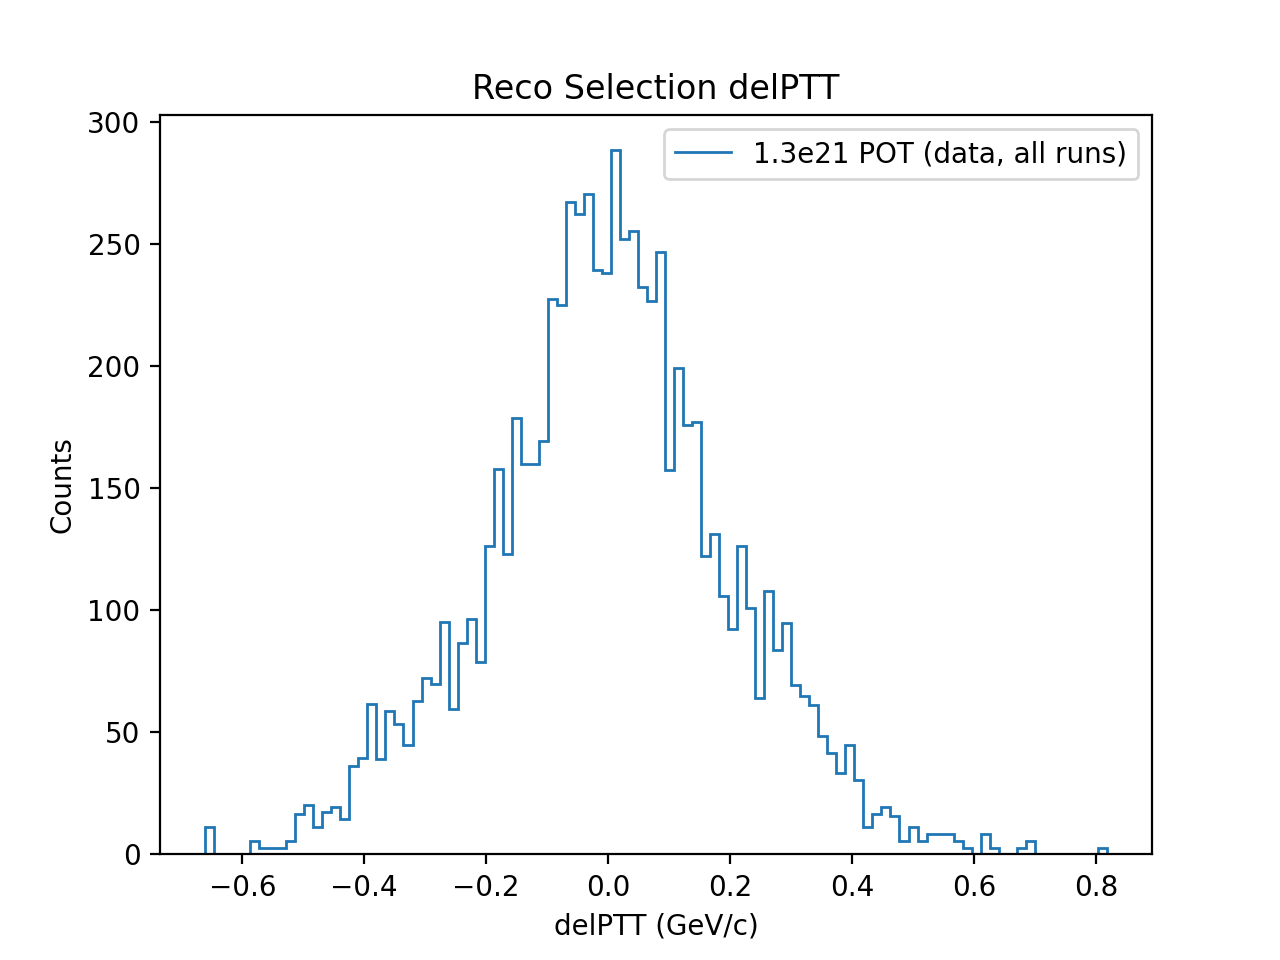

In [11]:
# delPTT reco plot

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(reco_delPTT_arr, bins=100, weights=reco_weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Selection delPTT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


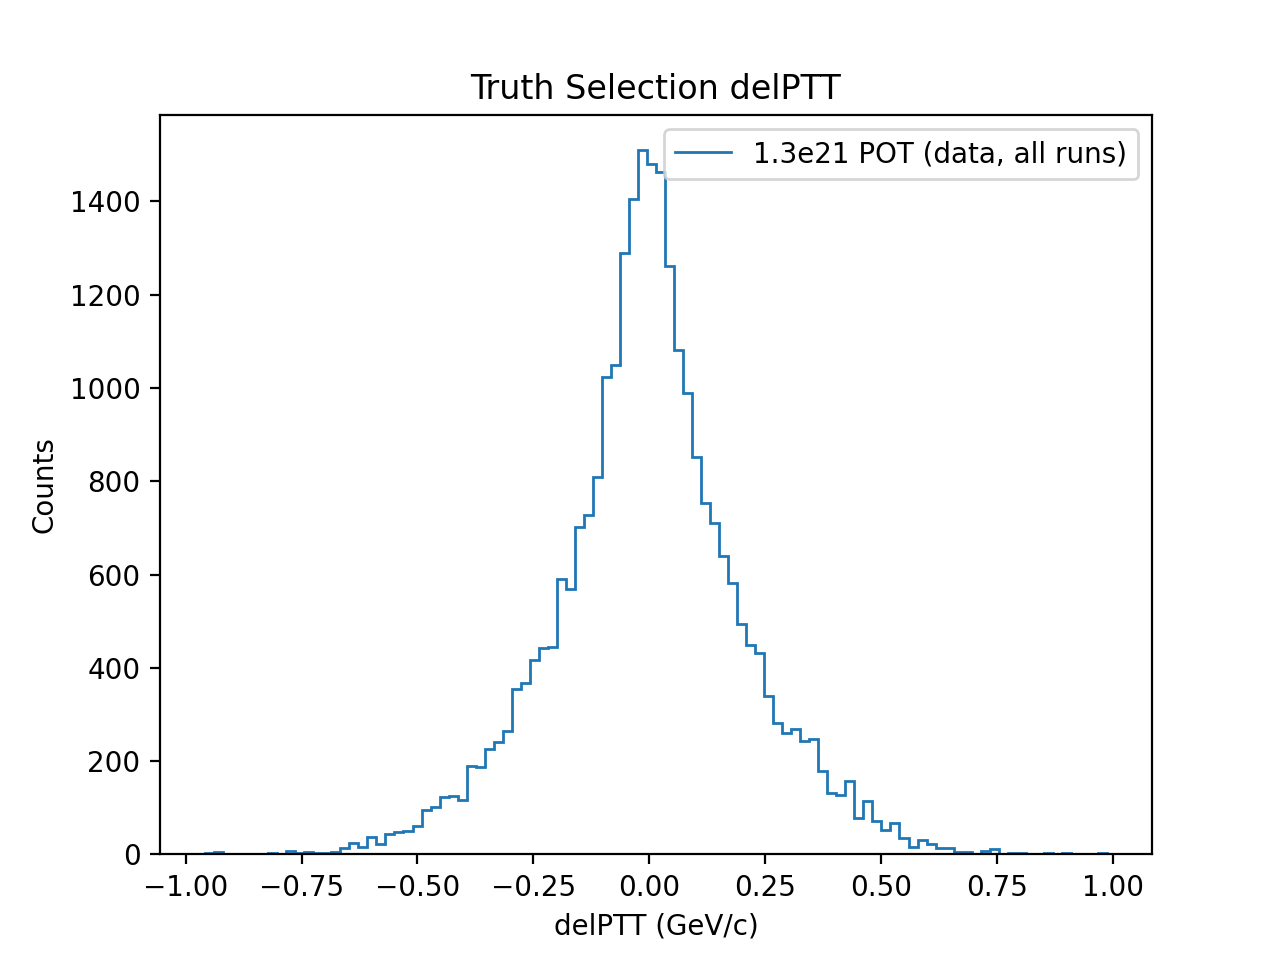

In [12]:
# delPTT truth plot

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(truth_delPTT_arr, bins=100, weights=truth_weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('Truth Selection delPTT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


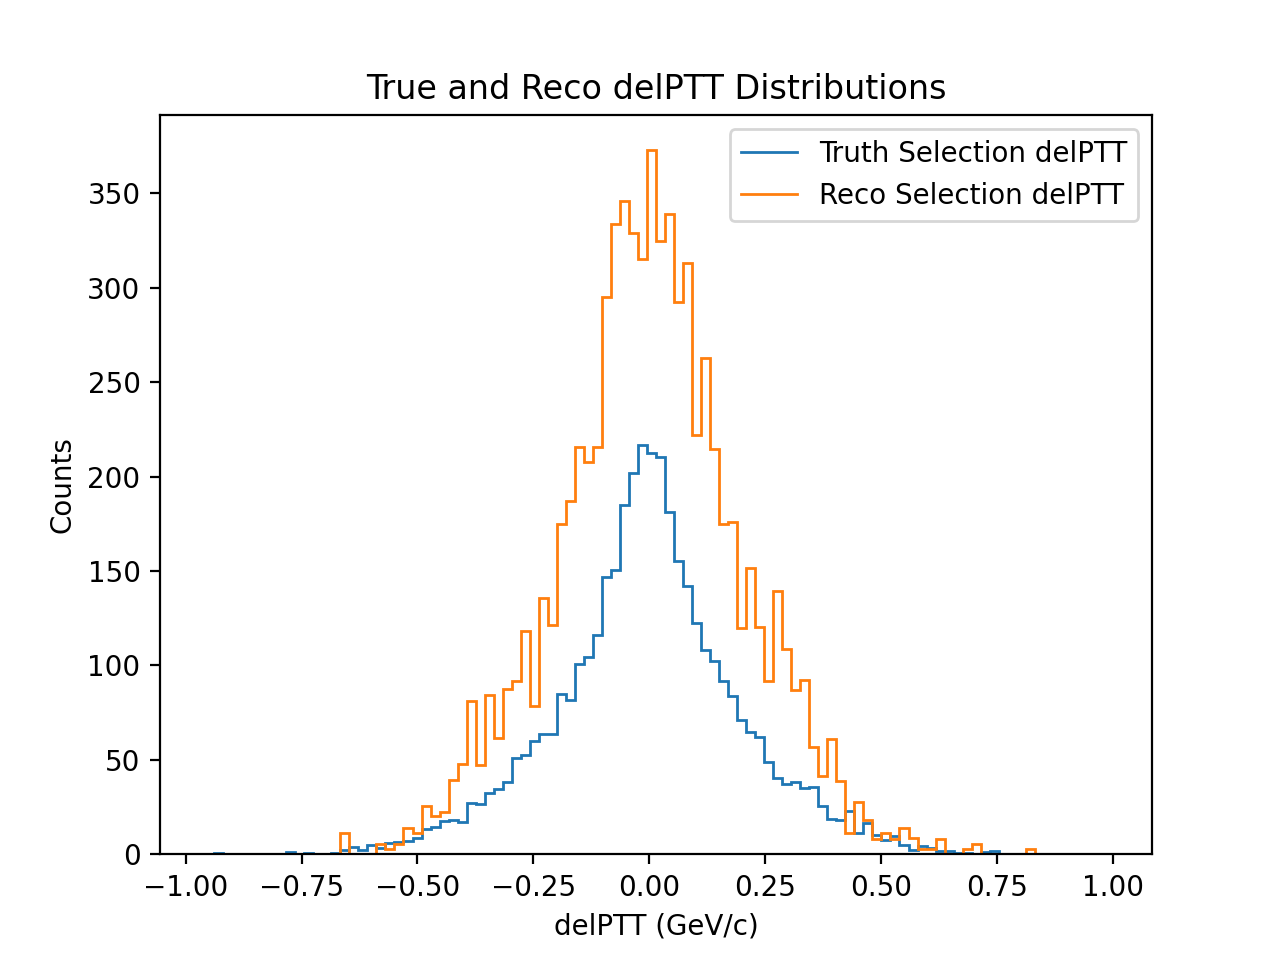

(9964,)
(9964,)
(2765,)
(2765,)
max value of truth:  0.9874523079886299
max value of reco:  0.8179067751147356
maxRange:  0.9874523079886299
truth bins:  [-0.95814402 -0.93868805 -0.91923209 -0.89977613 -0.88032016 -0.8608642
 -0.84140824 -0.82195228 -0.80249631 -0.78304035 -0.76358439 -0.74412842
 -0.72467246 -0.7052165  -0.68576053 -0.66630457 -0.64684861 -0.62739264
 -0.60793668 -0.58848072 -0.56902475 -0.54956879 -0.53011283 -0.51065686
 -0.4912009  -0.47174494 -0.45228897 -0.43283301 -0.41337705 -0.39392108
 -0.37446512 -0.35500916 -0.33555319 -0.31609723 -0.29664127 -0.2771853
 -0.25772934 -0.23827338 -0.21881741 -0.19936145 -0.17990549 -0.16044952
 -0.14099356 -0.1215376  -0.10208163 -0.08262567 -0.06316971 -0.04371374
 -0.02425778 -0.00480182  0.01465415  0.03411011  0.05356607  0.07302203
  0.092478    0.11193396  0.13138992  0.15084589  0.17030185  0.18975781
  0.20921378  0.22866974  0.2481257   0.26758167  0.28703763  0.30649359
  0.32594956  0.34540552  0.36486148  0.38431

In [13]:
# delPTT truth and reco plot for comparison (distributions)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

# Creating bins (should be same for truth and reco if plotted together)
numberBins = 100

maxTruth = np.max(truth_delPTT_arr)
maxReco = np.max(reco_delPTT_arr)
maxRange = maxReco if maxReco > maxTruth else maxTruth

minTruth = np.min(truth_delPTT_arr)
minReco = np.min(reco_delPTT_arr)
minRange = minReco if minReco < minTruth else minTruth

binEdgeRange = (minRange, maxRange)

print(truth_delPTT_arr.shape)
print(truth_weights_arr.shape)
print(reco_delPTT_arr.shape)
print(reco_weights_arr.shape)

print("max value of truth: ", maxTruth)
print("max value of reco: ", maxReco)
print("maxRange: ", maxRange)

countsTrue, binsTrue = np.histogram(truth_delPTT_arr, bins=numberBins, weights=truth_weights_arr, range=binEdgeRange)
scaledCountsTrue = (countsTrue*scale)/6.96

print("truth bins: ", binsTrue)

print(sum(countsTrue))
print(sum(scaledCountsTrue))

countsReco, binsReco = np.histogram(reco_delPTT_arr, bins=numberBins, weights=reco_weights_arr, range=binEdgeRange)
scaledCountsReco = countsReco*scale

print("reco bins: ", binsReco)

print(sum(countsReco))
print(sum(scaledCountsReco))

plt.stairs(scaledCountsTrue, binsTrue, label="Truth Selection delPTT")
plt.stairs(scaledCountsReco, binsReco, label="Reco Selection delPTT")

plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('True and Reco delPTT Distributions')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


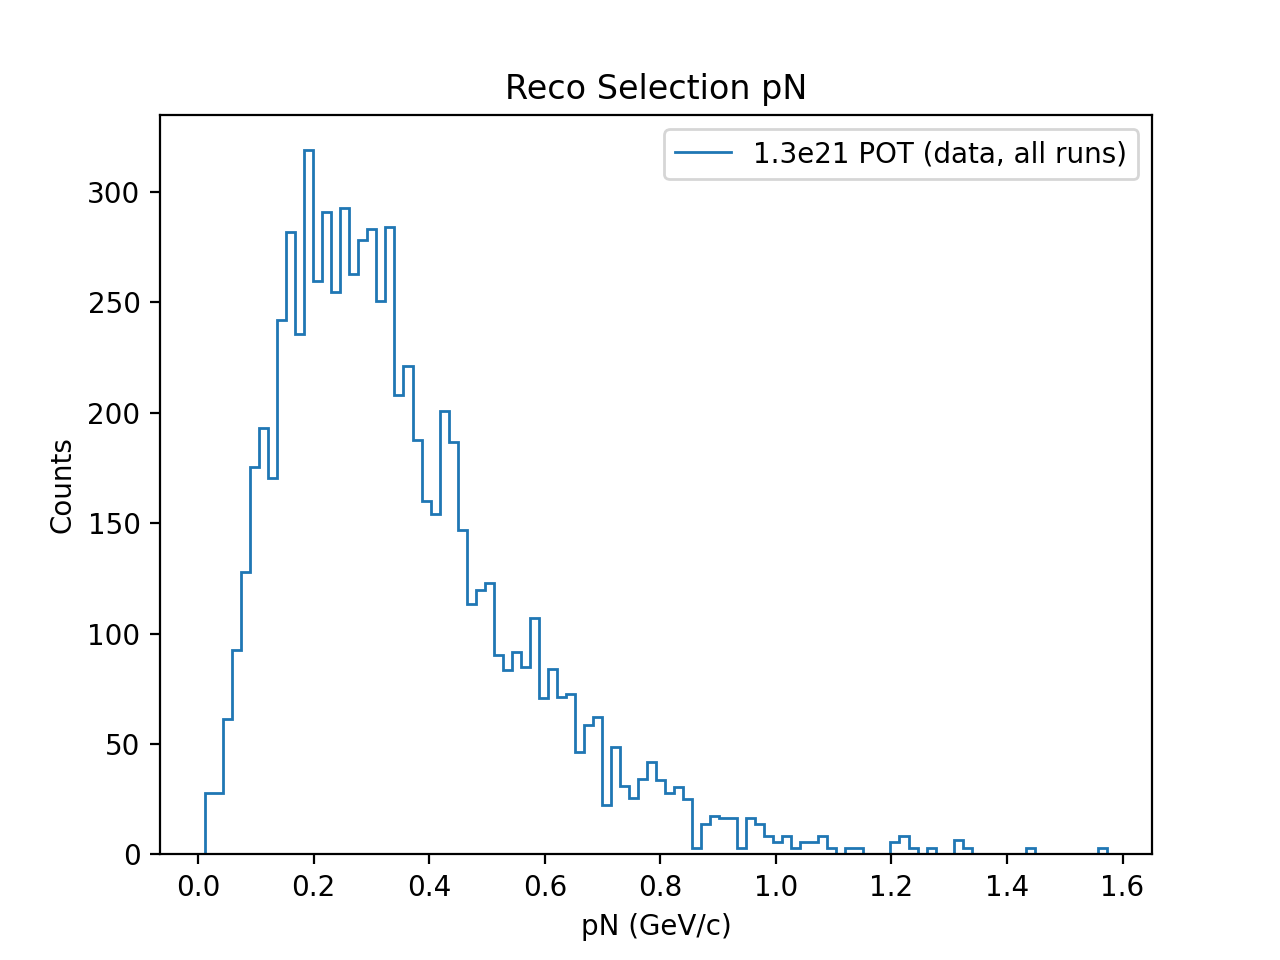

In [14]:
# pN reco plot

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(reco_pN_arr, bins=100, weights=reco_weights_arr)
scaledCounts = counts*scale

plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")

plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Selection pN')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


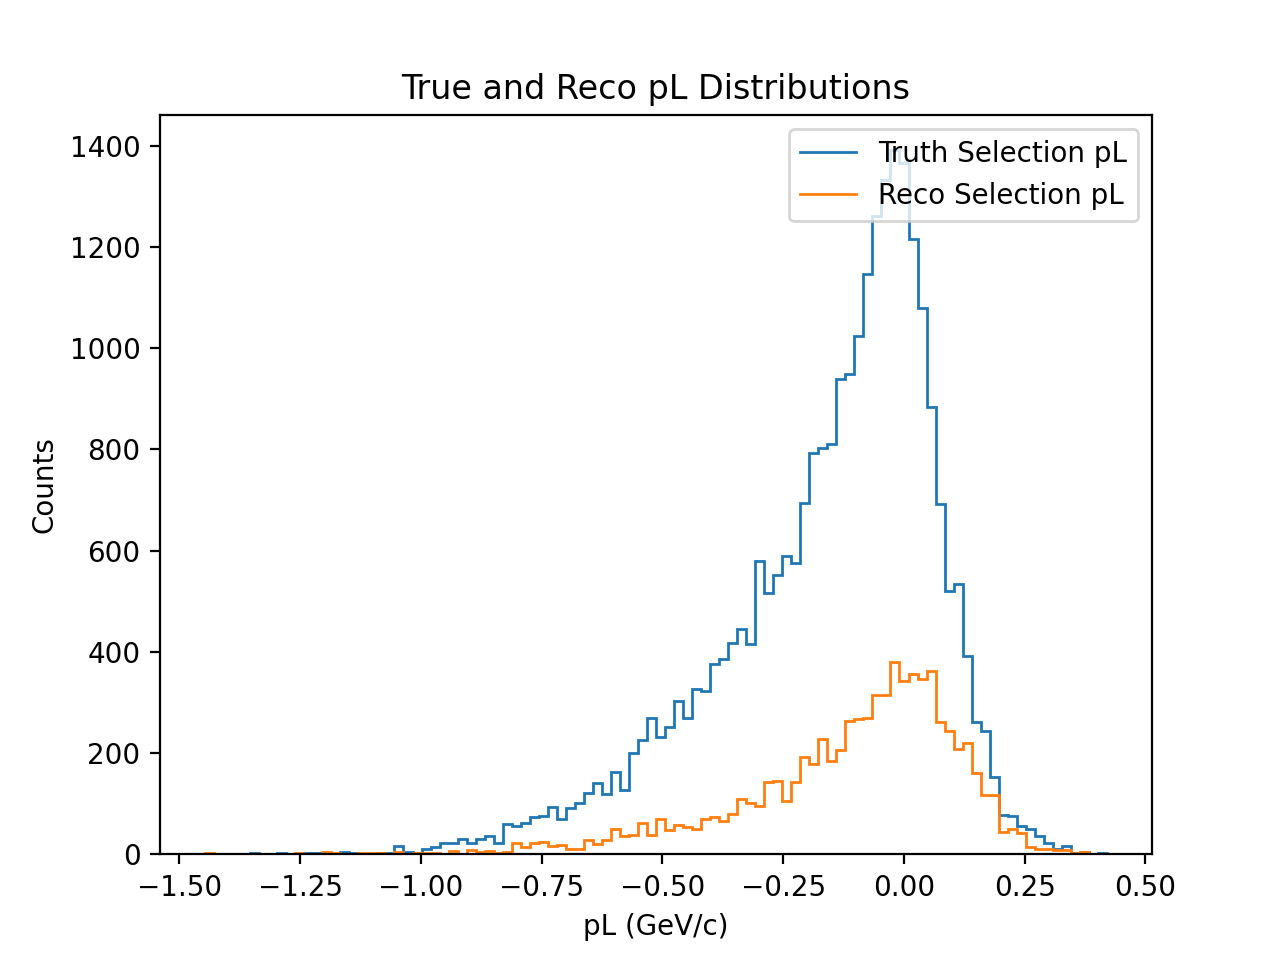

max value of truth:  0.420222241326357
max value of reco:  0.37570749347804266
maxRange:  0.420222241326357
(9964, 3)
(9964,)
(2765, 3)
(2765,)
truth bins:  [-1.44696445 -1.42829258 -1.40962071 -1.39094885 -1.37227698 -1.35360511
 -1.33493325 -1.31626138 -1.29758951 -1.27891765 -1.26024578 -1.24157391
 -1.22290205 -1.20423018 -1.18555831 -1.16688644 -1.14821458 -1.12954271
 -1.11087084 -1.09219898 -1.07352711 -1.05485524 -1.03618338 -1.01751151
 -0.99883964 -0.98016778 -0.96149591 -0.94282404 -0.92415217 -0.90548031
 -0.88680844 -0.86813657 -0.84946471 -0.83079284 -0.81212097 -0.79344911
 -0.77477724 -0.75610537 -0.73743351 -0.71876164 -0.70008977 -0.68141791
 -0.66274604 -0.64407417 -0.6254023  -0.60673044 -0.58805857 -0.5693867
 -0.55071484 -0.53204297 -0.5133711  -0.49469924 -0.47602737 -0.4573555
 -0.43868364 -0.42001177 -0.4013399  -0.38266804 -0.36399617 -0.3453243
 -0.32665243 -0.30798057 -0.2893087  -0.27063683 -0.25196497 -0.2332931
 -0.21462123 -0.19594937 -0.1772775  -0.1586

In [15]:
# pL truth and reco plot for comparison (distributions)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

# Creating bins (should be same for truth and reco if plotted together)
numberBins = 100

maxTruth = np.max(truth_pL_arr)
maxReco = np.max(reco_pL_arr)
maxRange = maxReco if maxReco > maxTruth else maxTruth

minTruth = np.min(truth_pL_arr)
minReco = np.min(reco_pL_arr)
minRange = minReco if minReco < minTruth else minTruth

binEdgeRange = (minRange, maxRange)

print("max value of truth: ", maxTruth)
print("max value of reco: ", maxReco)
print("maxRange: ", maxRange)

print(truth_delPT_arr.shape)
print(truth_weights_arr.shape)
print(reco_delPT_arr.shape)
print(reco_weights_arr.shape)

countsTrue, binsTrue = np.histogram(truth_pL_arr, bins=numberBins, weights=truth_weights_arr, range=binEdgeRange)
scaledCountsTrue = countsTrue*scale

print("truth bins: ", binsTrue)

print(sum(countsTrue))
print(sum(scaledCountsTrue))

countsReco, binsReco = np.histogram(reco_pL_arr, bins=numberBins, weights=reco_weights_arr, range=binEdgeRange)
scaledCountsReco = countsReco*scale

print("reco bins: ", binsReco)

print(sum(countsReco))
print(sum(scaledCountsReco))

plt.stairs(scaledCountsTrue, binsTrue, label="Truth Selection pL")
plt.stairs(scaledCountsReco, binsReco, label="Reco Selection pL")

plt.xlabel('pL (GeV/c)')
plt.ylabel('Counts')
plt.title('True and Reco pL Distributions')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


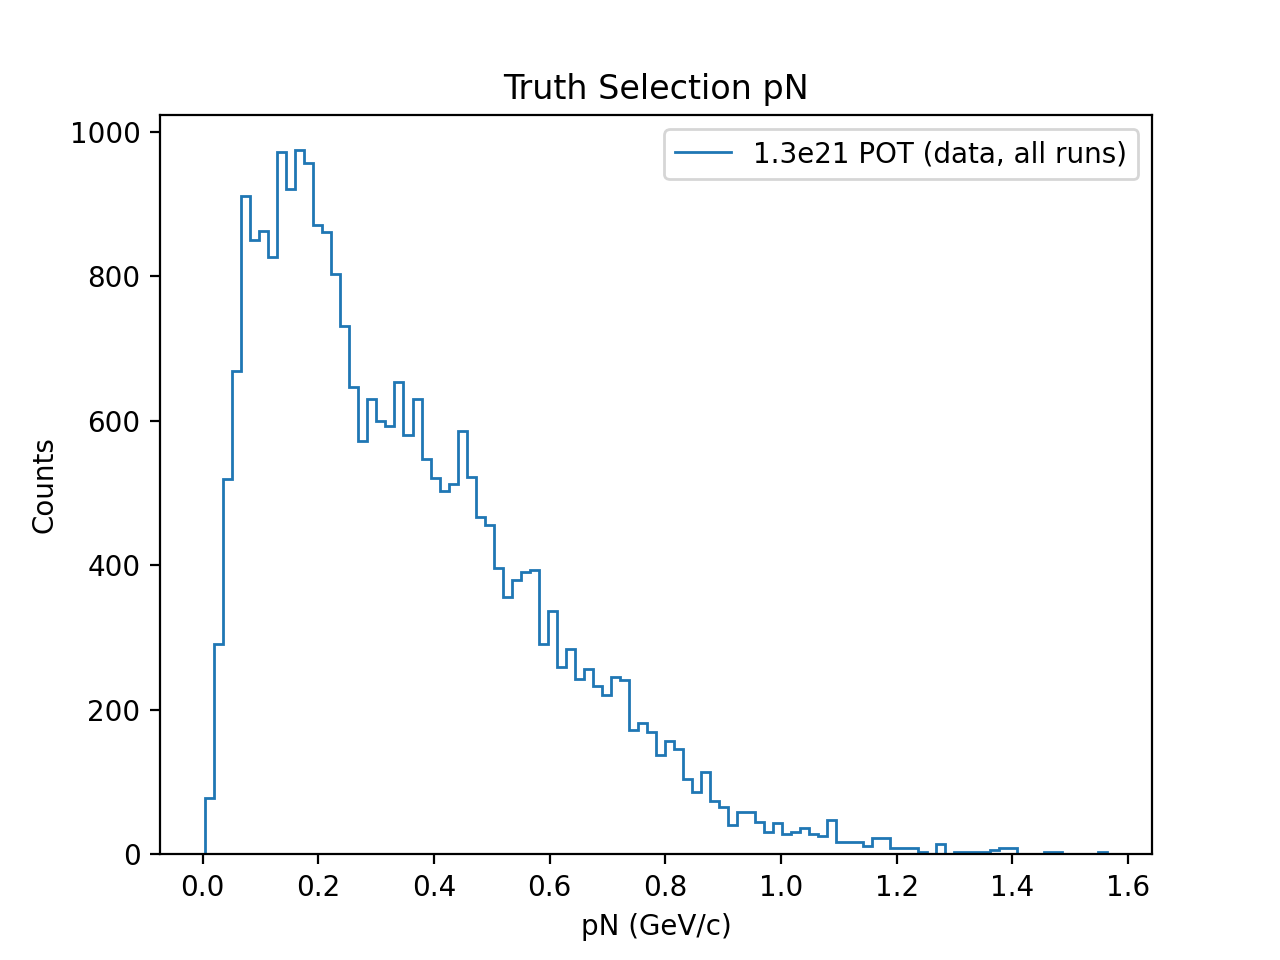

In [16]:
# pN truth plot

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(truth_pN_arr, bins=100, weights=truth_weights_arr)
scaledCounts = counts*scale

plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")

plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.title('Truth Selection pN')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


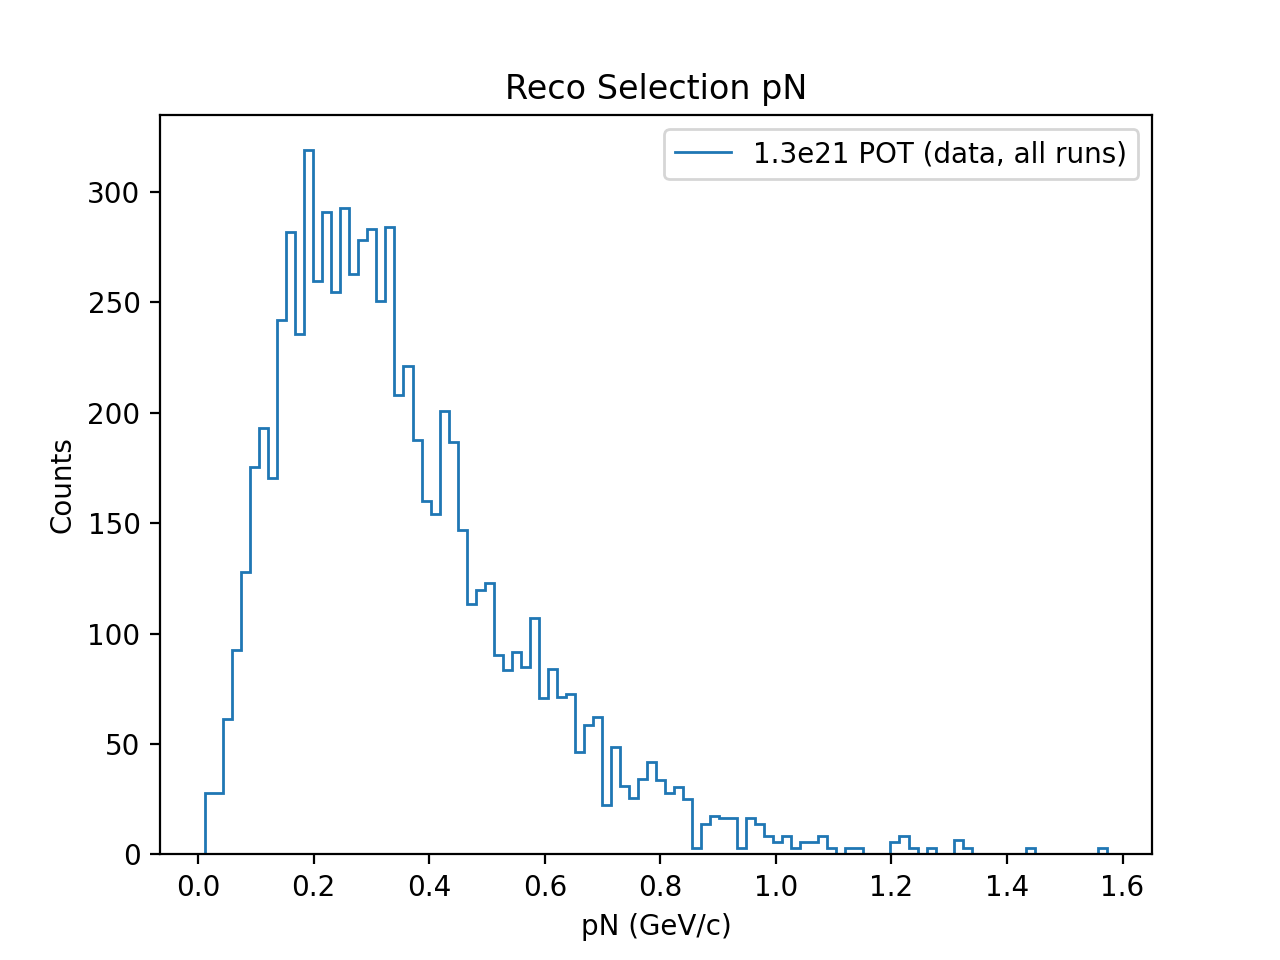

In [17]:
# pN reco plot

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(reco_pN_arr, bins=100, weights=reco_weights_arr)
scaledCounts = counts*scale

plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")

plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Selection pN')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


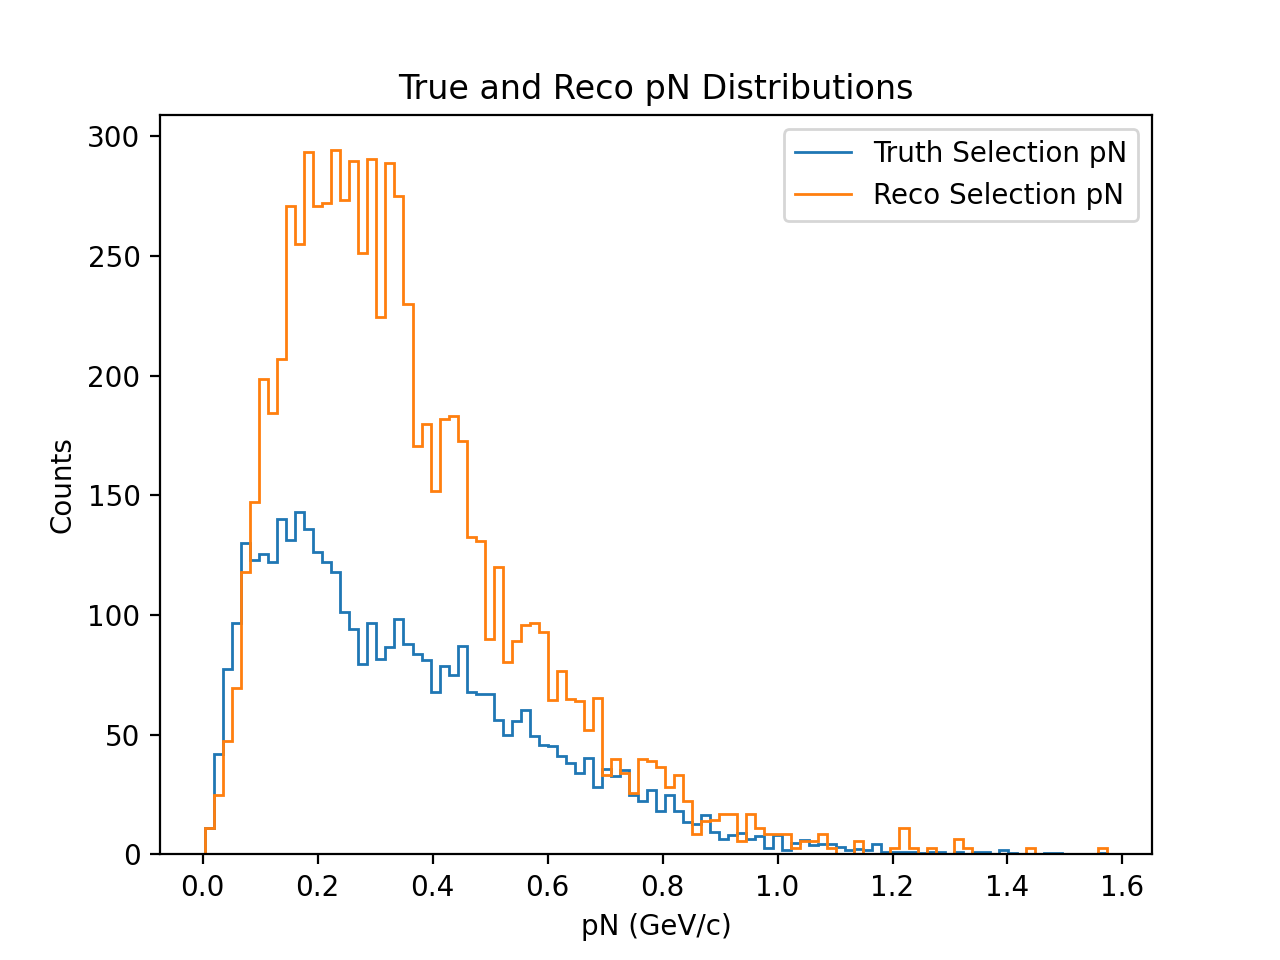

max value of truth:  1.5635113485953938
max value of reco:  1.5729412240147813
maxRange:  1.5729412240147813
(9964, 3)
(9964,)
(2765, 3)
(2765,)
truth bins:  [0.00431489 0.02000115 0.03568742 0.05137368 0.06705994 0.08274621
 0.09843247 0.11411873 0.129805   0.14549126 0.16117752 0.17686379
 0.19255005 0.20823631 0.22392258 0.23960884 0.2552951  0.27098137
 0.28666763 0.30235389 0.31804016 0.33372642 0.34941268 0.36509895
 0.38078521 0.39647147 0.41215774 0.427844   0.44353026 0.45921653
 0.47490279 0.49058905 0.50627532 0.52196158 0.53764784 0.55333411
 0.56902037 0.58470663 0.6003929  0.61607916 0.63176542 0.64745169
 0.66313795 0.67882421 0.69451048 0.71019674 0.725883   0.74156927
 0.75725553 0.77294179 0.78862806 0.80431432 0.82000058 0.83568685
 0.85137311 0.86705937 0.88274564 0.8984319  0.91411816 0.92980443
 0.94549069 0.96117695 0.97686322 0.99254948 1.00823574 1.02392201
 1.03960827 1.05529453 1.0709808  1.08666706 1.10235332 1.11803959
 1.13372585 1.14941211 1.16509838 1.18

In [18]:
# pN truth and reco plot for comparison (distributions)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

# Creating bins (should be same for truth and reco if plotted together)
numberBins = 100

maxTruth = np.max(truth_pN_arr)
maxReco = np.max(reco_pN_arr)
maxRange = maxReco if maxReco > maxTruth else maxTruth

minTruth = np.min(truth_pN_arr)
minReco = np.min(reco_pN_arr)
minRange = minReco if minReco < minTruth else minTruth

binEdgeRange = (minRange, maxRange)

print("max value of truth: ", maxTruth)
print("max value of reco: ", maxReco)
print("maxRange: ", maxRange)

print(truth_delPT_arr.shape)
print(truth_weights_arr.shape)
print(reco_delPT_arr.shape)
print(reco_weights_arr.shape)

countsTrue, binsTrue = np.histogram(truth_pN_arr, bins=numberBins, weights=truth_weights_arr, range=binEdgeRange)
scaledCountsTrue = (countsTrue*scale)/6.96

print("truth bins: ", binsTrue)

print(sum(countsTrue))
print(sum(scaledCountsTrue))

countsReco, binsReco = np.histogram(reco_pN_arr, bins=numberBins, weights=reco_weights_arr, range=binEdgeRange)
scaledCountsReco = countsReco*scale

print("reco bins: ", binsReco)

print(sum(countsReco))
print(sum(scaledCountsReco))

plt.stairs(scaledCountsTrue, binsTrue, label="Truth Selection pN")
plt.stairs(scaledCountsReco, binsReco, label="Reco Selection pN")

plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.title('True and Reco pN Distributions')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


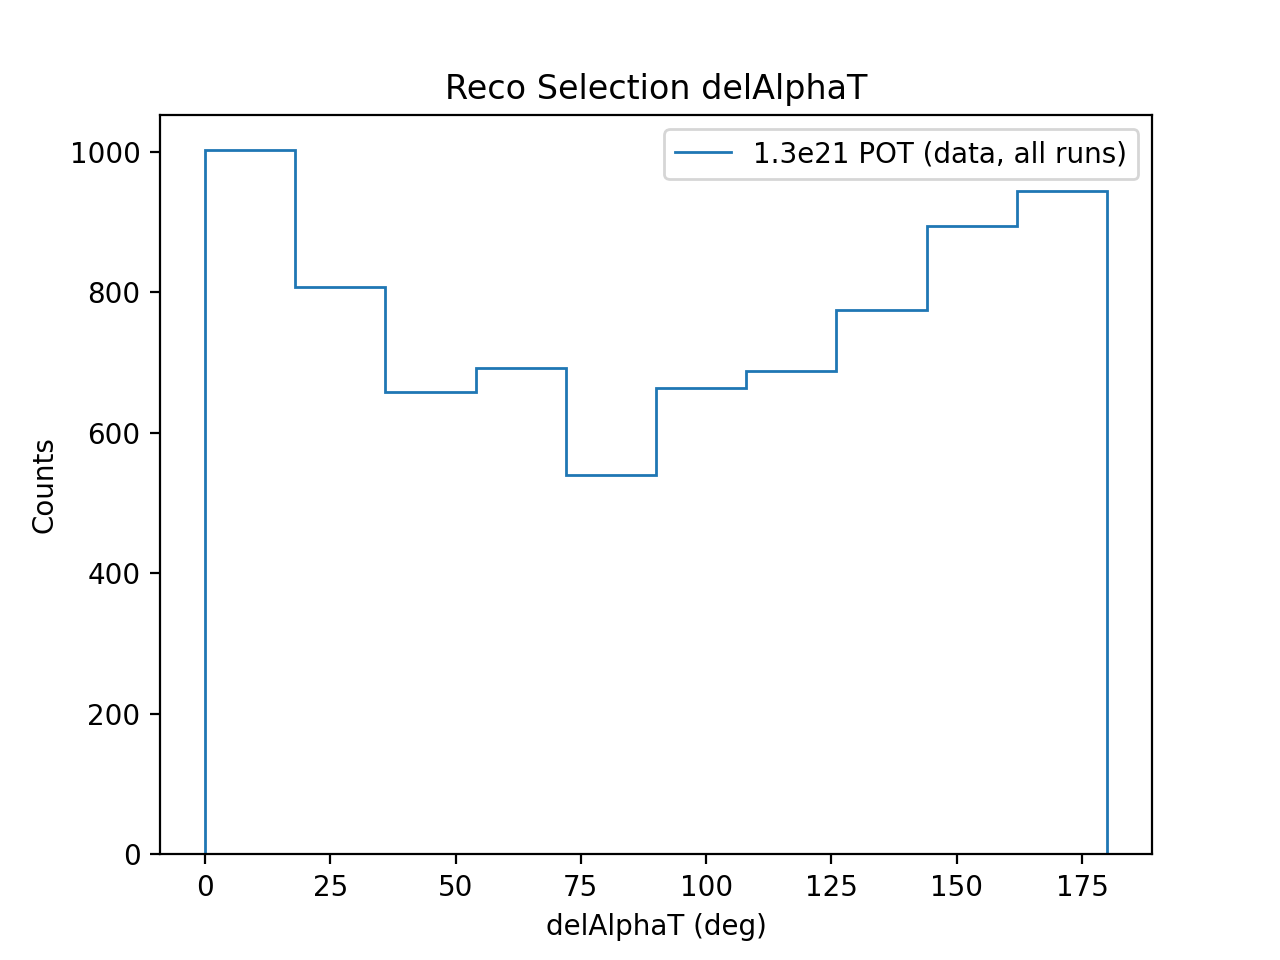

In [19]:
# delAlphaT reco plot

reco_delAlphaT_deg = reco_delAlphaT_arr*(180/np.pi)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(reco_delAlphaT_deg, bins=10, weights=reco_weights_arr)
scaledCounts = counts*scale

plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")

plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.title('Reco Selection delAlphaT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


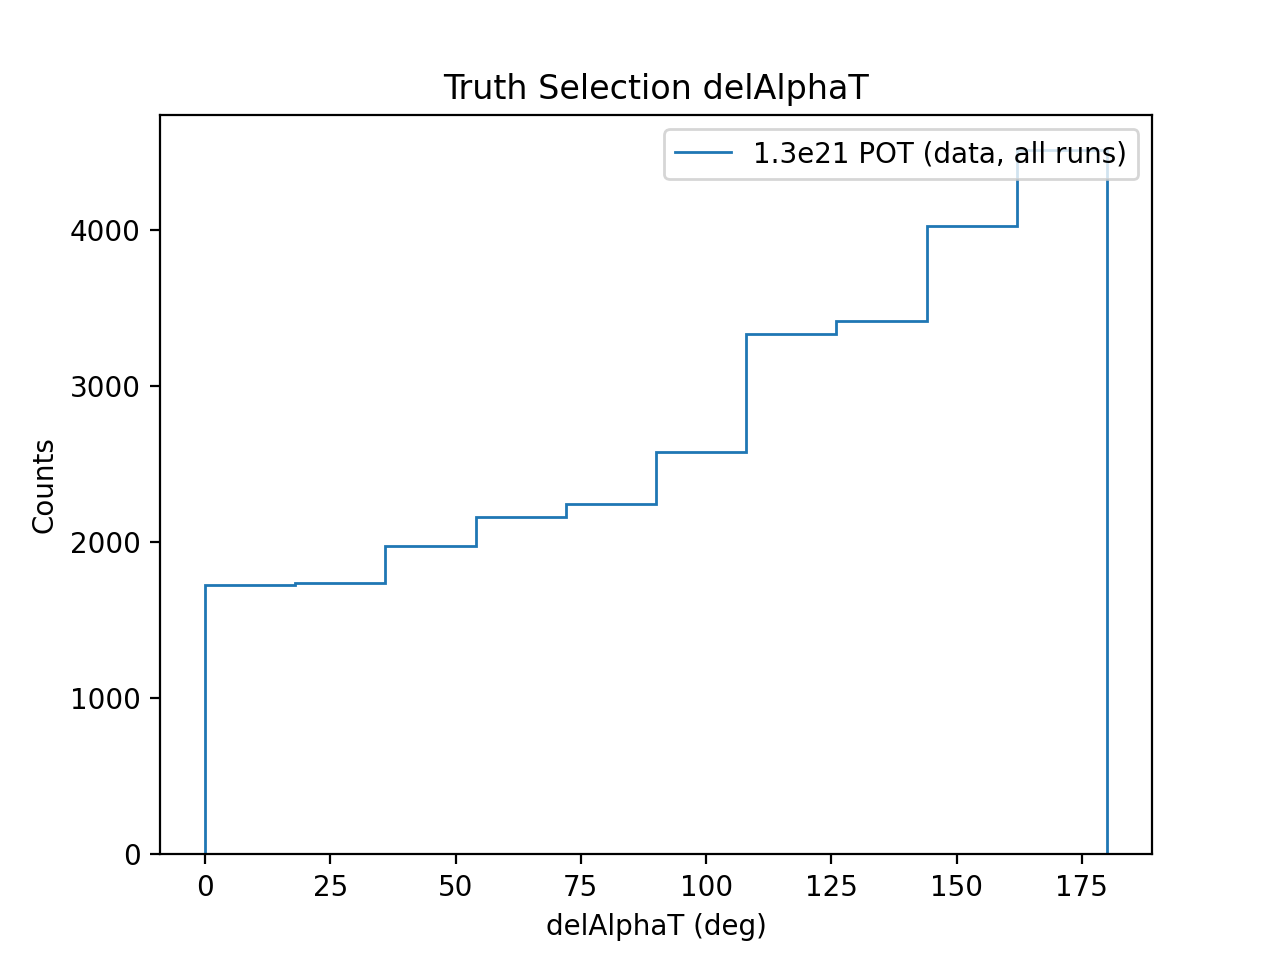

In [20]:
# delAlphaT truth plot

truth_delAlphaT_deg = truth_delAlphaT_arr*(180/np.pi)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(truth_delAlphaT_deg, bins=10, weights=truth_weights_arr)
scaledCounts = counts*scale

plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")

plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.title('Truth Selection delAlphaT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


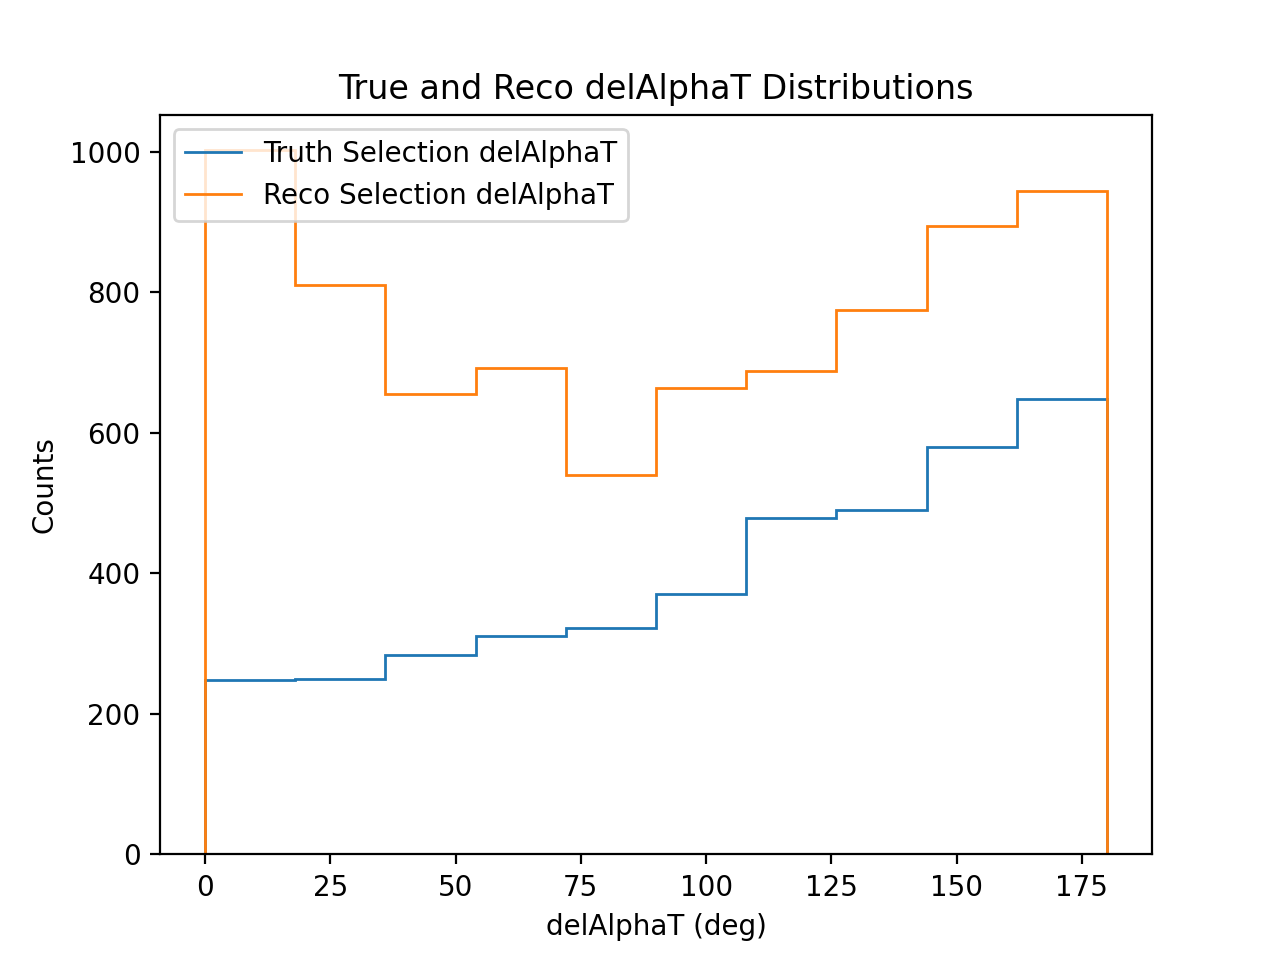

max value of truth:  179.9926016826059
max value of reco:  179.98100313495695
maxRange:  179.9926016826059
truth bins:  [6.61126585e-03 1.80052103e+01 3.60038093e+01 5.40024084e+01
 7.20010074e+01 8.99996065e+01 1.07998206e+02 1.25996805e+02
 1.43995404e+02 1.61994003e+02 1.79992602e+02]
9977.248706321414
3981.9798476697847
reco bins:  [6.61126585e-03 1.80052103e+01 3.60038093e+01 5.40024084e+01
 7.20010074e+01 8.99996065e+01 1.07998206e+02 1.25996805e+02
 1.43995404e+02 1.61994003e+02 1.79992602e+02]
2759.6499766424636
7665.694379562398


In [21]:
# delAlphaT truth and reco plot for comparison (distributions)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

reco_delAlphaT_deg = reco_delAlphaT_arr*(180/np.pi)
truth_delAlphaT_deg = truth_delAlphaT_arr*(180/np.pi)

# Creating bins (should be same for truth and reco if plotted together)
numberBins = 10

maxTruth = np.max(truth_delAlphaT_deg)
maxReco = np.max(reco_delAlphaT_deg)
maxRange = maxReco if maxReco > maxTruth else maxTruth

minTruth = np.min(truth_delAlphaT_deg)
minReco = np.min(reco_delAlphaT_deg)
minRange = minReco if minReco < minTruth else minTruth

binEdgeRange = (minRange, maxRange)

print("max value of truth: ", maxTruth)
print("max value of reco: ", maxReco)
print("maxRange: ", maxRange)

countsTrue, binsTrue = np.histogram(truth_delAlphaT_deg, bins=numberBins, weights=truth_weights_arr, range=binEdgeRange)
scaledCountsTrue = (countsTrue*scale)/6.96

print("truth bins: ", binsTrue)

print(sum(countsTrue))
print(sum(scaledCountsTrue))

countsReco, binsReco = np.histogram(reco_delAlphaT_deg, bins=numberBins, weights=reco_weights_arr, range=binEdgeRange)
scaledCountsReco = countsReco*scale

print("reco bins: ", binsReco)

print(sum(countsReco))
print(sum(scaledCountsReco))

plt.stairs(scaledCountsTrue, binsTrue, label="Truth Selection delAlphaT")
plt.stairs(scaledCountsReco, binsReco, label="Reco Selection delAlphaT")

plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.title('True and Reco delAlphaT Distributions')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left")

<IPython.core.display.Javascript object>


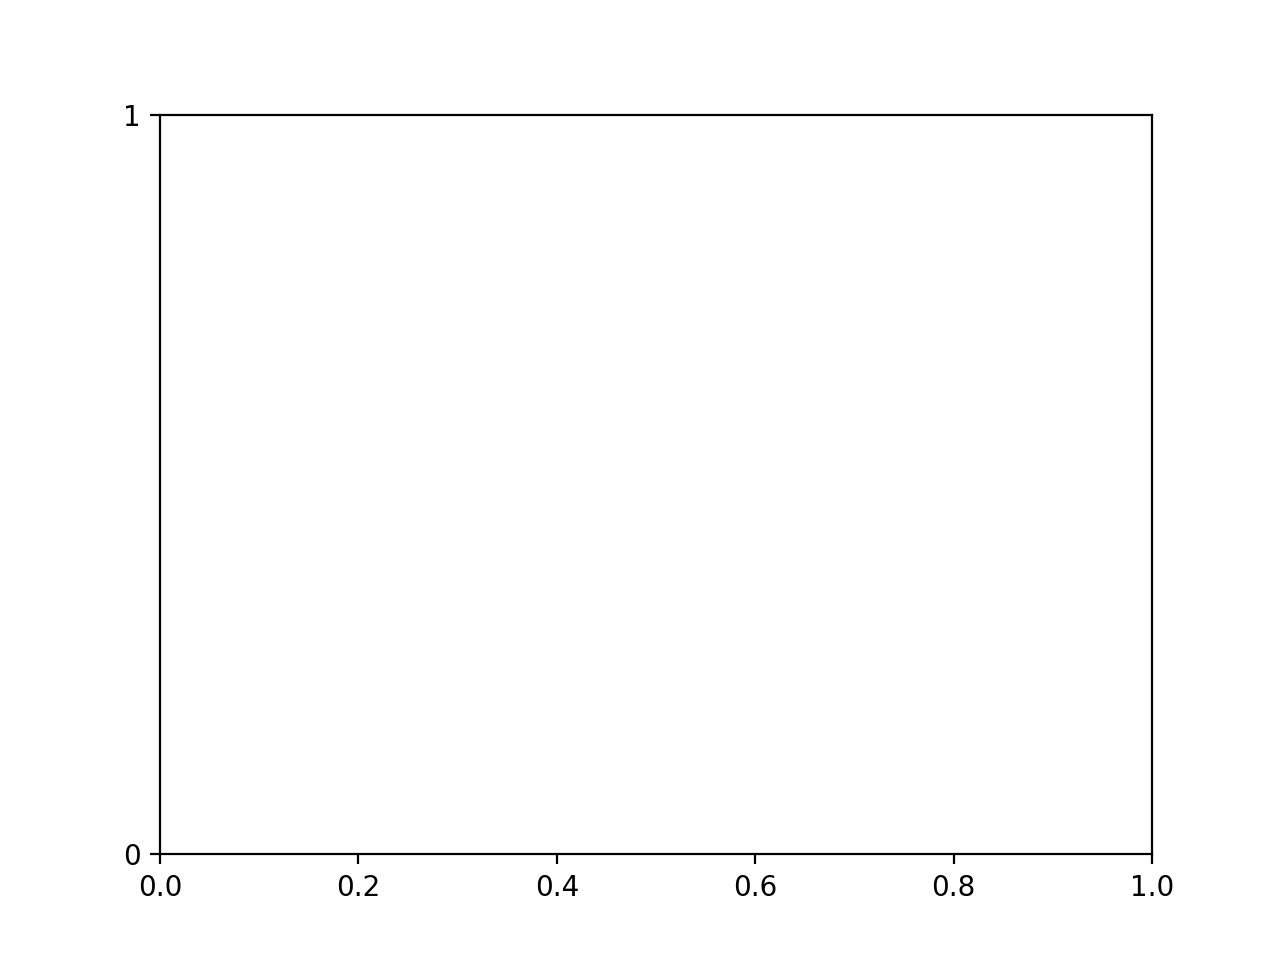

NameError: name 'recoMuMom_arr' is not defined

In [22]:
# reco muon mom

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(recoMuMom_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('Reco Muon Momentum (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Muon Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [ ]:
# reco pion mom

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(recoPiMom_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('Reco Pion Momentum (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Pion Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [ ]:
# reco leading proton mom

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(recoLPMom_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('Reco Leading Proton Momentum (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Leading Proton Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)